# **UNet Segmentation using Google Colaboratory**

Download the dataset from Kaggle or Github:

      - To download from github use "git clone https://github.com/panthole/data-science-bowl-2018.git"
      - Compress the data and put in a zip file "zip -r data.zip [path]"
      - Upload the data into Google Colaboratory
      - Unzip the file using "!unzip data.zip"

**1. Data Preparation**

In [0]:
# !unzip data.zip

**2. Imports**

In [0]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

**3. Data Generators**

In [0]:
# Data Generator

class DataGen(keras.utils.Sequence):
  def __init__(self, ids, path, batch_size = 8, image_size = 128):
    self.ids = ids
    self.path = path
    self.batch_size = batch_size
    self.image_size = image_size
    self.on_epoch_end()
    
  def __load__(self, id_name):
    image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
    mask_path = os.path.join(self.path, id_name, "masks/")
    all_masks = os.listdir(mask_path)
    
    # Reading Image
    image = cv2.imread(image_path, 1)
    image = cv2.resize(image, (self.image_size, self.image_size))
      
    mask = np.zeros((self.image_size, self.image_size, 1))
      
    # Reading Mask
    for name in all_masks:
      _mask_path = mask_path + name
      _mask_image = cv2.imread(_mask_path, -1)
      _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size))
      _mask_image = np.expand_dims(_mask_image, axis = -1)
      mask = np.maximum(mask, _mask_image)
      
    image = image/255.
    mask = mask/255.
    
    return image, mask
  
  def __getitem__(self, index):
    if(index+1)*self.batch_size > len(self.ids):
      self.batch_size = len(self.ids) - index*self.batch_size
      
    files_batch = self.ids[index*self.batch_size : (index + 1)* self.batch_size]
    
    image = []
    mask = []
    
    for id_name in files_batch:
      _img, _mask = self.__load__(id_name)
      image.append(_img)
      mask.append(_mask)
      
    image = np.array(image)
    mask = np.array(mask)
    
    return image, mask
  
  def on_epoch_end(self):
    pass
  
  def __len__(self):
    return int(np.ceil(len(self.ids)/float(self.batch_size)))
    

**4. Hyperparamters**

In [0]:
## Hyperparameters

image_size = 128
train_path = "data-science-bowl-2018/stage1_train/"
epochs = 10
batch_size = 8

# Train Ids
train_ids = next(os.walk(train_path))[1]

# Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]


In [74]:
gen = DataGen(train_ids, train_path, batch_size = batch_size, image_size = image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


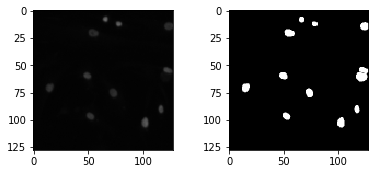

In [75]:
r = random.randint(0, len(x) - 1)

fig = plt.figure()
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap = 'gray')

**5. Convolutional Blocks**

In [0]:
def down_block(x, filters, kernel_size = (3,3), padding = 'same', strides =1):
  c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = 'relu')(x)
  c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = 'relu')(c)
  p = keras.layers.MaxPool2D((2,2),(2,2))(c)
  return c, p

def up_block(x, skip, filters, kernel_size = (3,3), padding = 'same', strides = 1):
  us = keras.layers.UpSampling2D((2,2))(x)
  concat = keras.layers.Concatenate()([us, skip])
  c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = 'relu')(concat)
  c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = 'relu')(c)
  return c

def bottleneck(x, filters, kernel_size = (3,3), padding = 'same', strides = 1):
  c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = 'relu')(x)
  c = keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = 'relu')(c)
  return c

**6. UNet Model**

In [0]:
# UNet Model
def UNet():
  f = [16, 32, 64, 128, 256]
  inputs = keras.layers.Input((image_size, image_size, 3))
  
  p0 = inputs
  c1, p1 = down_block(p0, f[0])
  c2, p2 = down_block(p1, f[1])
  c3, p3 = down_block(p2, f[2])
  c4, p4 = down_block(p3, f[3])
  
  bn = bottleneck(p4, f[4])
  
  u1 = up_block(bn, c4, f[3])
  u2 = up_block(u1, c3, f[2])
  u3 = up_block(u2, c2, f[1])
  u4 = up_block(u3, c1, f[0])
  
  outputs = keras.layers.Conv2D(1, (1,1), padding = 'same', activation = 'sigmoid')(u4)
  model = keras.models.Model(inputs, outputs)
  return model

In [78]:
model = UNet()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 128, 128, 16) 448         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_96[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_97[0][0]                  
__________________________________________________________________________________________________
conv2d_98 

**7. Training the UNet  Model**

In [79]:
# Training the model

train_gen = DataGen(train_ids, train_path, image_size = image_size, batch_size = batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size = image_size, batch_size = batch_size)

train_steps = len(train_ids)// batch_size
valid_steps = len(valid_ids)// batch_size

model.fit_generator(train_gen, validation_data = valid_gen, steps_per_epoch = train_steps, validation_steps = valid_steps, epochs = epochs)

Epoch 1/10
83/83 [==============================] - 19s 233ms/step - loss: 2.0516 - acc: 0.8217 - val_loss: 1.8103 - val_acc: 0.8744
Epoch 2/10
83/83 [==============================] - 18s 212ms/step - loss: 1.0354 - acc: 0.8531 - val_loss: 0.4507 - val_acc: 0.8810
Epoch 3/10
83/83 [==============================] - 18s 212ms/step - loss: 0.7186 - acc: 0.9142 - val_loss: 0.2691 - val_acc: 0.9292
Epoch 4/10
83/83 [==============================] - 18s 214ms/step - loss: 0.5323 - acc: 0.9321 - val_loss: 0.2291 - val_acc: 0.9374
Epoch 5/10
83/83 [==============================] - 18s 216ms/step - loss: 0.4635 - acc: 0.9388 - val_loss: 0.2234 - val_acc: 0.9387
Epoch 6/10
83/83 [==============================] - 18s 214ms/step - loss: 0.4618 - acc: 0.9393 - val_loss: 0.2050 - val_acc: 0.9429
Epoch 7/10
83/83 [==============================] - 18s 217ms/step - loss: 0.4542 - acc: 0.9400 - val_loss: 0.2078 - val_acc: 0.9399
Epoch 8/10
83/83 [==============================] - 18s 214ms/step - 

**8. Testing the UNet Model**

In [0]:
# Testing Model
model.save_weights('UNetW.h5')

# Prediction Dataset
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

**Visualizing the Results**

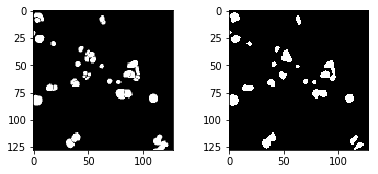

In [81]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace = 0.4)

ax = fig.add_subplot(1,2,1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap='gray')

ax = fig.add_subplot(1,2,2)
ax.imshow(np.reshape(result[0]*255,(image_size, image_size)), cmap = 'gray')

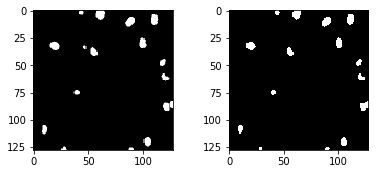

In [82]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1,2,1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap = 'gray')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap = 'gray')